In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#linear model to compare with hgbc 
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, mean_squared_error
from scipy.stats import uniform
from sklearn.utils import resample
from sklearn import metrics

import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in data from csv
filename = 'creditcard.csv'
file = open(filename, 'rt')
reader = csv.reader(file, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)
data = np.array(x)

In [3]:
#standard data set test split
#remove headers and split features from labels
header, raw_data = np.vsplit(data, [1])
raw_x, raw_y = np.hsplit(raw_data, [30])
x_train, x_val, y_train, y_val = train_test_split(raw_x, raw_y, test_size=0.25)

#ALL ABOARD THE DATA TRAIN CH0000000 CH0000000000
data_train, data_test = train_test_split(raw_data, test_size=0.25)
x_test, y_test = np.hsplit(data_test, [30])
print(np.shape(data_train))
print(np.shape(raw_data))
#create np array for cases with class 1
index = np.where(data_train=='"1"')[0]
raw_1 = np.split(data_train[index], np.where(np.diff(index)=='"0"')[0]+1)
raw_1 = np.array(raw_1)
i1, j1, k1 = np.shape(raw_1)
#print("raw_1 shape: ", np.shape(raw_1))

#create np array for case 0
index = np.where(data_train=='"0"')[0]
raw_0 = np.split(data_train[index], np.where(np.diff(index)=='"1"')[0]+1)
raw_0 = np.array(raw_0)
i0, j0, k0 = np.shape(raw_0)
#print("raw_0 shape: ", np.shape(raw_0))

raw_0 = np.reshape(raw_0, (j0, 31))
raw_1 = np.reshape(raw_1, (j1, 31))

#Upsampled------------------------------------------------------------------------------------
#create upsample for class "1", and append to class "0" data
upsampled_1 = resample(raw_1, replace = True, n_samples = 284315, random_state=42)
upsampled_data = np.append(raw_0, upsampled_1, axis = 0)

#split upsampled data 
header, upsample_no_header = np.vsplit(upsampled_data, [1])
upsample_x, upsample_y = np.hsplit(upsample_no_header, [30])
#x_train_up, x_val_up, y_train_up, y_val_up = train_test_split(upsample_x, upsample_y, test_size=0.25)

#Downsampled------------------------------------------------------------------------------------
#create downsample for class "1", and append to class "0" data
downsampled_1 = resample(raw_0, replace = True, n_samples = 492, random_state=42)
downsampled_data = np.append(raw_1, downsampled_1, axis = 0)

#split downsampled data------------------------------------------------------------------------------------
header, downsample_no_header = np.vsplit(downsampled_data, [1])
downsample_x, downsample_y = np.hsplit(downsample_no_header, [30])
#x_train_down, x_val_down, y_train_down, y_val_down = train_test_split(downsample_x, downsample_y, test_size=0.25)

#Balanced------------------------------------------------------------------------------------
#downsample majority class to half its size and upsample minority class to match
mid_1 = resample(raw_1, replace = True, n_samples = 142158, random_state=42)
mid_0 = resample(raw_0, replace = True, n_samples = 142158, random_state=42)
mid_data = np.append(mid_0, mid_1, axis = 0)

header, mid_no_header = np.vsplit(mid_data, [1])
mid_x, mid_y = np.hsplit(mid_no_header, [30])
#x_train_mid, x_val_mid, y_train_down, y_val_mid = train_test_split(mid_x, mid_y, test_size=0.25)




(213605, 31)
(284807, 31)


C:\Users\Apsara\AppData\Local\Temp\ipykernel_5104\1241616235.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raw_1 = np.split(data_train[index], np.where(np.diff(index)=='"0"')[0]+1)
C:\Users\Apsara\AppData\Local\Temp\ipykernel_5104\1241616235.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  raw_0 = np.split(data_train[index], np.where(np.diff(index)=='"1"')[0]+1)


In [ ]:
#grid search on HistGradientBoostingClasifier with k k-folds and f1 scorer; param=parameter list; x and y are x train and y train
def gridSearch(param, x, y, k):
    classifier = HistGradientBoostingClassifier(early_stopping=False)
    scorer = make_scorer(f1_score, pos_label='"1"')
    grid = GridSearchCV(classifier, param_grid=param, scoring=scorer, cv = k)
    model = grid.fit(x, np.ravel(y))
    return grid

#random search on HistGradientBoostingClasifier cv = k, x and y are training sets
def randSearch(distribution, x, y, k):
    classifier = HistGradientBoostingClassifier(early_stopping=False)
    scorer = make_scorer(f1_score, pos_label='"1"')
    randSearch = RandomizedSearchCV(classifier, distribution, random_state=0, scoring=scorer, cv = k)
    model = randSearch.fit(x, np.ravel(y))
    return randSearch

#function for plotting results
def plotResults(x, y, x_label, y_label, title):
    plt.plot(x, y)
    plt.title(title, fontsize=18)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.grid('on')
    plt.show

#function for confusion matrix plot
def plotConfusionMatrix(model, x, y):
    titles = [
    ("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles:
        disp = ConfusionMatrixDisplay.from_estimator(
            model, x, np.ravel(y), cmap=plt.cm.Blues, normalize = normalize
        )
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()

    

In [ ]:
max_iter = np.linspace(10, 2500, 25, dtype=int)
param = {'class_weight': [{0:.4, 1:.6}], 'learning_rate': [0.1], 'max_iter': max_iter, 'max_leaf_nodes': [None], 'early_stopping': [False]}
model = gridSearch(param, upsample_x, upsample_y, 2)

{'class_weight': {0: 0.4, 1: 0.6}, 'early_stopping': False, 'learning_rate': 0.1, 'max_iter': 736, 'max_leaf_nodes': None}
0.9999297764644284
Confusion matrix, without normalization
[[71423     8]
 [    0 70727]]
Normalized confusion matrix
[[9.99888004e-01 1.11996192e-04]
 [0.00000000e+00 1.00000000e+00]]


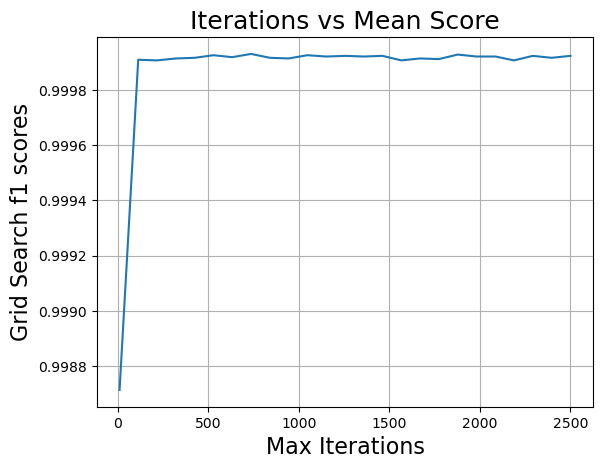

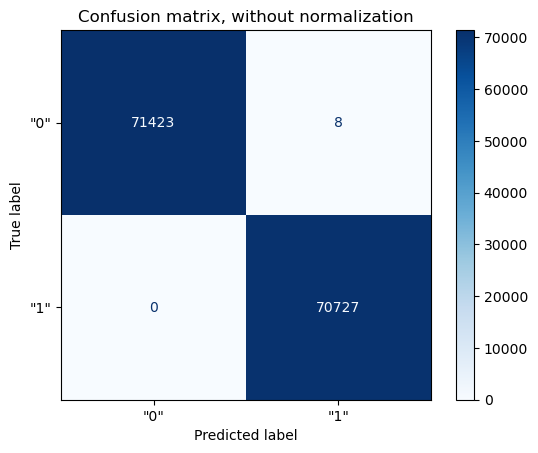

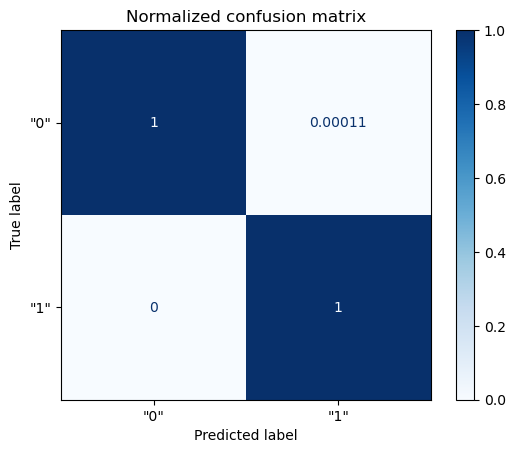

In [ ]:
print(model.best_params_)
print(model.best_score_)

#get mean test scores from the grid search
mean_scores = model.cv_results_['mean_test_score']
mean_scores = np.delete(mean_scores, [0,1])
x_iter = np.delete(max_iter, [0,1])
#plot max iterations vs mean test scores
plotResults(x_iter, mean_scores, "Max Iterations", 'Grid Search f1 scores',  "Iterations vs Mean Score")

#plot confusion matrix using best estimator and test sets
plotConfusionMatrix(model, x_test, y_test)


In [ ]:
#grid search through range of class weights without upsampling
weights = np.linspace(0.0, 1.0, 40)    #weight range
param = {'class_weight': [{0:x, 1:1.0-x} for x in weights], 'learning_rate': [0.1], 'max_iter': [740], 'max_leaf_nodes': [None]}
model = gridSearch(param, x_train, y_train, 2)

In [ ]:
print(model.best_estimator_)
print(model.best_score_)

HistGradientBoostingClassifier(class_weight={0: 0.1282051282051282,
                                             1: 0.8717948717948718},
                               max_iter=740, max_leaf_nodes=None)
0.8514769830559303


Confusion matrix, without normalization
[[71067     8]
 [    9   118]]
Normalized confusion matrix
[[9.99887443e-01 1.12557158e-04]
 [7.08661417e-02 9.29133858e-01]]


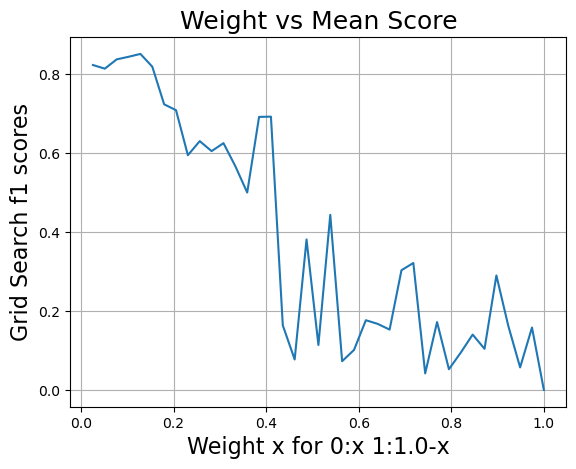

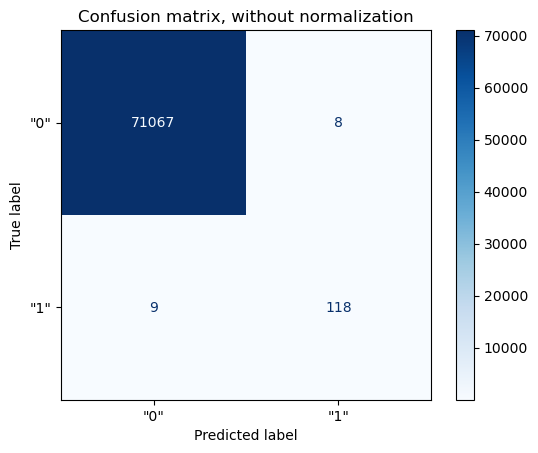

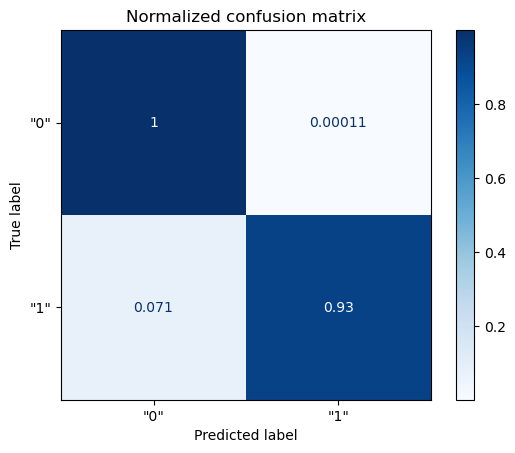

In [ ]:
#get mean test scores from the grid search
mean_scores = model.cv_results_['mean_test_score']
#x_iter = np.delete(weights, [0])
mean_scores = np.delete(mean_scores, [0])
#plot max iterations vs mean test scores
plotResults(x_iter, mean_scores, "Weight x for 0:x 1:1.0-x", 'Grid Search f1 scores',  "Weight vs Mean Score")

#plot confusion matrix using best estimator and test sets
plotConfusionMatrix(model, x_val, y_val)


In [ ]:
#grid search through range of max iterations with upsampling##############
max_iter = np.linspace(10, 800, 30, dtype=int)
#weights = np.linspace(0.0, 1.0, 40)    #weight range
param = {'class_weight': [None], 'learning_rate': [0.1], 'max_iter': max_iter, 'max_leaf_nodes': [31]}
model_up = gridSearch(param, upsample_x, upsample_y, 3)

In [ ]:
print(model_up.best_estimator_.get_params(deep=True))
print(model_up.best_score_)
print(np.shape(model_up.cv_results_['mean_test_score']))

{'categorical_features': None, 'class_weight': None, 'early_stopping': False, 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_iter': 527, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.9999577952595199
(30,)


Confusion matrix, without normalization
[[71050     7]
 [   33   112]]
Normalized confusion matrix
[[9.99901488e-01 9.85124618e-05]
 [2.27586207e-01 7.72413793e-01]]


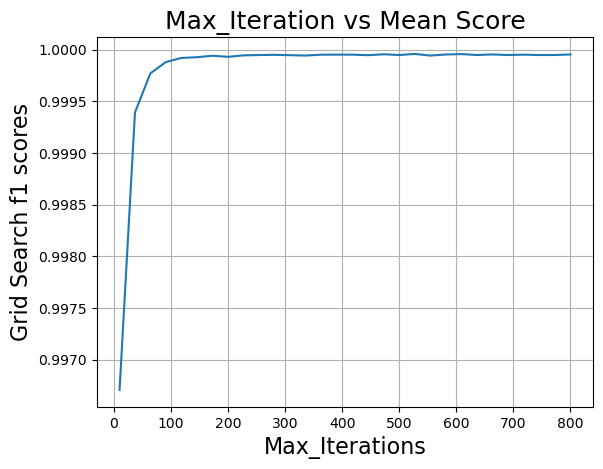

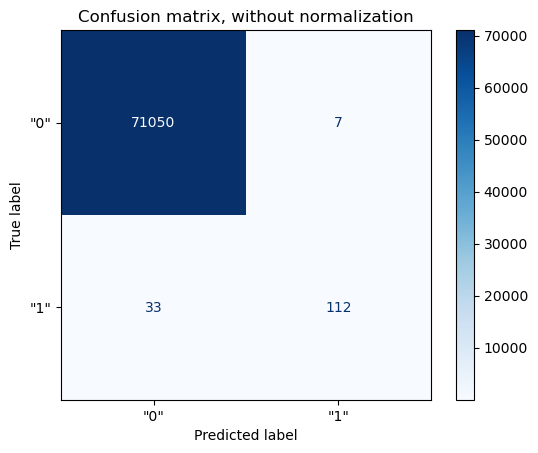

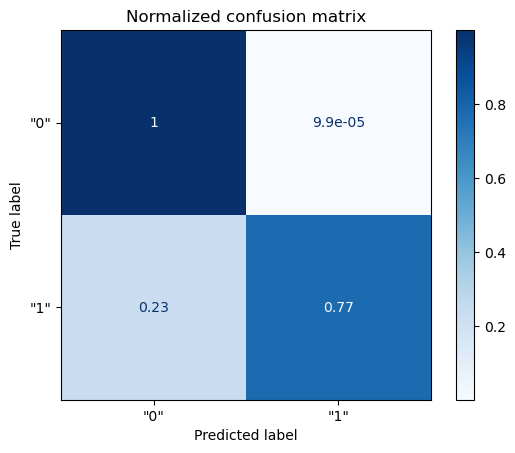

In [ ]:
#get mean test scores from the grid search
mean_scores = model_up.cv_results_['mean_test_score']
#mean_scores1, mean_scores2 = np.split(mean_scores, 2)
plotResults(max_iter, mean_scores, "Max_Iterations", 'Grid Search f1 scores',  "Max_Iteration vs Mean Score")

#plot confusion matrix using best estimator and test sets
plotConfusionMatrix(model_up, x_test, y_test)


In [ ]:
print(np.shape(downsample_x))

(853, 30)


In [ ]:
#grid search through range of max iterations with downsampling
max_iter = np.linspace(10, 1600, 80, dtype=int)
#weights = np.linspace(0.0, 1.0, 40)    #weight range
param = {'class_weight': [None], 'learning_rate': [0.1], 'max_iter': max_iter}
model_down = gridSearch(param, downsample_x, downsample_y, 3)

Confusion matrix, without normalization
[[69426  1631]
 [   23   122]]
Normalized confusion matrix
[[0.9770466  0.0229534 ]
 [0.15862069 0.84137931]]


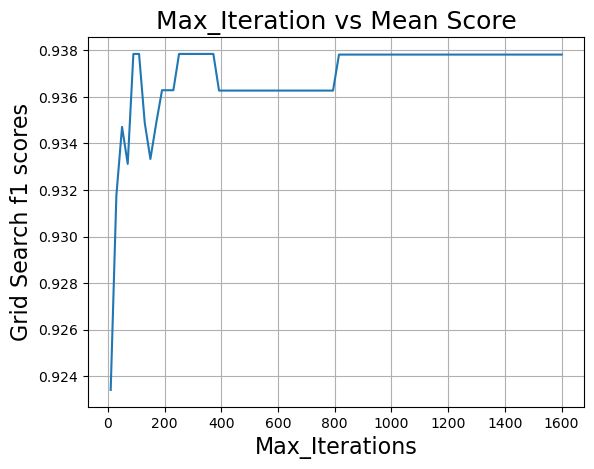

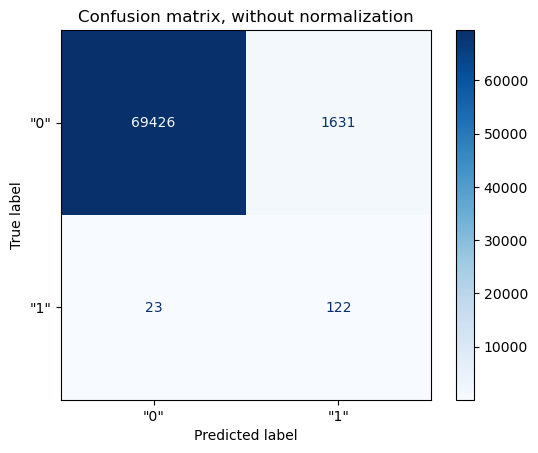

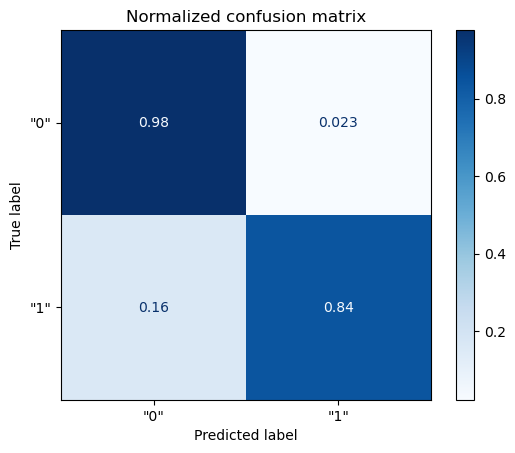

In [ ]:
#get mean test scores from the grid search
mean_scores = model_down.cv_results_['mean_test_score']

plotResults(max_iter, mean_scores, "Max_Iterations", 'Grid Search f1 scores',  "Max_Iteration vs Mean Score")

#plot confusion matrix using best estimator and test sets
plotConfusionMatrix(model_down, x_test, y_test)

In [ ]:
#grid search through range of max iterations with downsampling
max_iter = np.linspace(10, 1600, 80, dtype=int)
#weights = np.linspace(0.0, 1.0, 40)    #weight range
param = {'class_weight': [None], 'learning_rate': [0.1], 'max_iter': max_iter}
model_down = gridSearch(param, mid_x, mid_y, 3)

In [ ]:
#get mean test scores from the grid search
mean_scores = model_down.cv_results_['mean_test_score']

plotResults(max_iter, mean_scores, "Max_Iterations", 'Grid Search f1 scores',  "Max_Iteration vs Mean Score")

#plot confusion matrix using best estimator and test sets
plotConfusionMatrix(model_down, x_test, y_test)

c:\Users\jhol3\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jhol3\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion matrix, without normalization
[[71076    13]
 [   35    78]]
Normalized confusion matrix
[[9.99817131e-01 1.82869361e-04]
 [3.09734513e-01 6.90265487e-01]]


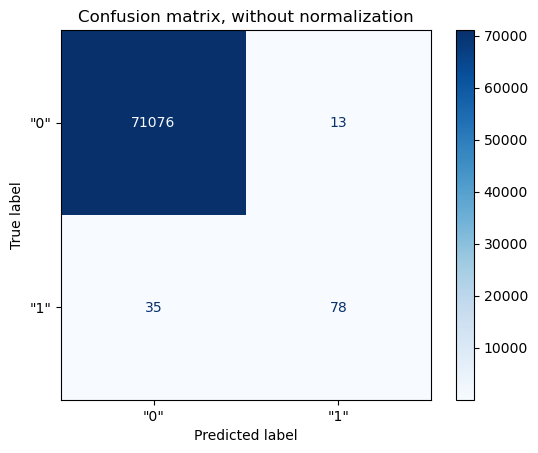

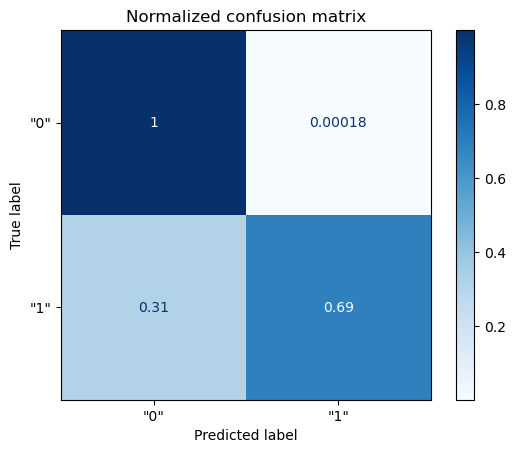

In [ ]:
#linear model to compare results linear support vector classifier
linModel = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
linModel.fit(x_train, y_train)
plotConfusionMatrix(linModel, x_val, np.ravel(y_val))